In [ ]:
#Você pode dizer isso para o seu cliente:

#Passo 1: Coloque a pasta do projeto na sua Área de Trabalho.

#Passo 2: Rode o Python (aperte o Play). Ele vai criar o Excel atualizado.

#Passo 3: Rode a Etapa 6. O Power BI vai abrir sozinho.

#Passo 4: No Power BI, clique no botão Atualizar. PRONTO! Os gráficosna frente dos seus olhos.#

In [28]:
# [MANUAL DE USO - ETAPA 1: CARREGAMENTO]
# 1. Digite o nome do relatório e suba sua planilha.
# 2. O sistema guardará os dados originais na gaveta 'DADOS_MESTRES'.

import pandas as pd
import io
import ipywidgets as widgets
from IPython.display import display, clear_output

input_nome = widgets.Text(value="Relatorio_TransLOG", description='📝 Nome:')
btn_upload = widgets.FileUpload(accept='.xlsx, .csv', description="📂 Subir Planilha", button_style='info')
tela_logs = widgets.Output()

def carregar_dados(change):
    with tela_logs:
        clear_output()
        if not btn_upload.value: return
        try:
            arquivo = btn_upload.value[0]
            # Lendo os dados originais
            if arquivo['name'].endswith('.csv'):
                df_original = pd.read_csv(io.BytesIO(arquivo['content']))
            else:
                df_original = pd.read_excel(io.BytesIO(arquivo['content']))
            
            # Limpa espaços nos nomes das colunas
            df_original.columns = df_original.columns.str.strip()
            
            # SALVANDO NA GAVETA MESTRE (Nunca será apagada)
            globals()['DADOS_MESTRES'] = df_original 
            
            print(f"✅ SUCESSO! {len(df_original)} linhas carregadas.")
            print(f"📋 Colunas lidas: {list(df_original.columns)}")
        except Exception as e:
            print(f"❌ ERRO: {e}")

btn_upload.observe(carregar_dados, names='value')
display(input_nome, btn_upload, tela_logs)

Text(value='Relatorio_TransLOG', description='📝 Nome:')

FileUpload(value=(), accept='.xlsx, .csv', button_style='info', description='📂 Subir Planilha')

Output()

📊 GERANDO RELATÓRIO FINANCEIRO...


,Centro de Custo,Valor Orçado,Valor Realizado,Diferença (R$),Status
0,Administrativo,68660.06,94026.18,25366.12,🔴 Acima
1,Combustível,154851.86,189881.17,35029.31,🔴 Acima
2,Frota,130830.02,145743.96,14913.94,🔴 Acima
3,Manutenção,105824.08,106375.73,551.65,🔴 Acima
4,Pedágio,151023.72,132009.02,-19014.70,🟢 OK
5,Pneus,152279.30,162050.24,9770.94,🔴 Acima


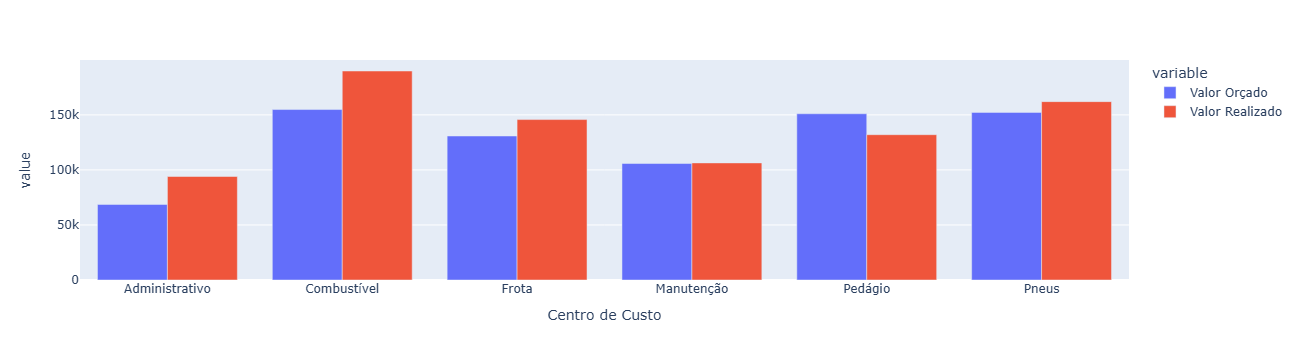

In [29]:
# [MANUAL DE USO - ETAPA 2: ANÁLISE FINANCEIRA]
# 1. Este bloco cria o resumo por Centro de Custo.
# 2. Ele usa uma CÓPIA dos dados, preservando a lista de veículos intacta.

import plotly.express as px

if 'DADOS_MESTRES' in locals():
    print("📊 GERANDO RELATÓRIO FINANCEIRO...")
    
    # Criamos o relatório usando a Gaveta Mestre
    relatorio_dre = DADOS_MESTRES.groupby('Centro de Custo').agg({
        'Valor Orçado': 'sum',
        'Valor Realizado': 'sum'
    }).reset_index()

    relatorio_dre['Diferença (R$)'] = relatorio_dre['Valor Realizado'] - relatorio_dre['Valor Orçado']
    relatorio_dre['Status'] = relatorio_dre['Diferença (R$)'].apply(lambda x: '🔴 Acima' if x > 0 else '🟢 OK')
    
    # Exibição
    display(relatorio_dre)
    fig = px.bar(relatorio_dre, x='Centro de Custo', y=['Valor Orçado', 'Valor Realizado'], barmode='group')
    fig.show()
else:
    print("⚠️ STATUS: Suba o arquivo na Célula 1 primeiro!")

In [16]:
# [MANUAL DE USO - ETAPA 3: KPIs DE FROTA]
# 1. Este bloco busca os veículos DIRETAMENTE da gaveta 'DADOS_MESTRES'.
# 2. Como a Célula 2 não mexeu na gaveta mestre, o erro de 'Veículo' vai sumir.

if 'DADOS_MESTRES' in locals():
    print("🚚 ANALISANDO EFICIÊNCIA POR VEÍCULO...")
    
    # Pegamos os dados purinhos da gaveta mestre
    df_frota = DADOS_MESTRES.copy()
    
    # Ajuste de nomes de colunas comum
    mapeamento = {'Veiculo': 'Veículo', 'Km': 'KM Rodado', 'KM': 'KM Rodado'}
    df_frota = df_frota.rename(columns=mapeamento)
    
    try:
        # Agrupamento por Veículo
        kpis_frota = df_frota.groupby('Veículo').agg({
            'Valor Realizado': 'sum',
            'KM Rodado': 'sum'
        }).reset_index()
        
        kpis_frota['Custo por KM'] = (kpis_frota['Valor Realizado'] / kpis_frota['KM Rodado']).round(2)
        
        # Mostra o resultado
        display(kpis_frota.sort_values(by='Custo por KM', ascending=False))
        
        media = kpis_frota['Custo por KM'].mean()
        print(f"\n📢 MÉDIA DA FROTA: R$ {media:.2f} por KM")
        
    except KeyError as e:
        print(f"❌ ERRO: A coluna {e} não foi encontrada na sua planilha.")
        print(f"📋 Suas colunas são: {list(df_frota.columns)}")
else:
    print("⚠️ STATUS: Rode a Célula 1 primeiro!")

🚚 ANALISANDO EFICIÊNCIA POR VEÍCULO...


,Veículo,Valor Realizado,KM Rodado,Custo por KM
2,CAM-003,135415.39,25037,5.41
0,CAM-001,149913.82,28138,5.33
4,CAM-005,205633.14,39372,5.22
3,CAM-004,173653.24,37637,4.61
1,CAM-002,165470.71,36864,4.49



📢 MÉDIA DA FROTA: R$ 5.01 por KM


In [30]:
## =================================================================================
# [MANUAL DE USO - ETAPA 4: EXPORTAÇÃO EXCEL]
# =================================================================================
import pandas as pd

if 'relatorio_dre' in locals() and 'kpis_frota' in locals():
    # Garante que o nome tenha .xlsx no final
    nome_base = input_nome.value if input_nome.value else "Relatorio_TransLOG"
    if not nome_base.endswith('.xlsx'):
        nome_base += '.xlsx'
    
    globals()['nome_final'] = nome_base  # Salva para as próximas etapas
    
    try:
        with pd.ExcelWriter(nome_final, engine='xlsxwriter') as writer:
            relatorio_dre.to_excel(writer, sheet_name='Resumo Financeiro', index=False)
            kpis_frota.to_excel(writer, sheet_name='Eficiência de Frota', index=False)
        
        print(f"✅ SUCESSO! O arquivo '{nome_final}' foi criado fisicamente na pasta.")
    except Exception as e:
        print(f"❌ ERRO AO SALVAR: {e}")
else:
    print("⚠️ STATUS: Realize as análises das Etapas 2 e 3 primeiro.")

✅ SUCESSO! O arquivo 'Relatorio_TransLOG.xlsx' foi criado fisicamente na pasta.


In [31]:
# =================================================================================
# [MANUAL DE USO - ETAPA 5: BACKUP E HISTÓRICO - VERSÃO CORRIGIDA]
# =================================================================================
# O QUE FAZ: Cria uma cópia de segurança para evitar perda de dados.
# POR QUE FALHOU ANTES? Provavelmente o arquivo da Etapa 4 não foi salvo no disco
# ou o nome gravado na memória não condiz com o arquivo na pasta.
# =================================================================================
# =================================================================================
# [MANUAL DE USO - ETAPA 5: BACKUP E HISTÓRICO]
# =================================================================================
import os
import shutil
from datetime import datetime

def executar_backup_seguranca(arquivo_para_copiar):
    # Correção automática de extensão
    if not arquivo_para_copiar.endswith('.xlsx'):
        arquivo_para_copiar += '.xlsx'
        
    pasta_backup = "Historico_Backups"
    
    if not os.path.exists(arquivo_para_copiar):
        print(f"❌ ERRO: O arquivo '{arquivo_para_copiar}' não existe no seu computador.")
        return

    try:
        if not os.path.exists(pasta_backup):
            os.makedirs(pasta_backup)
        
        carimbo = datetime.now().strftime("%Y-%m-%d_%H-%M")
        nome_backup = f"Backup_{carimbo}_{arquivo_para_copiar}"
        caminho_final = os.path.join(pasta_backup, nome_backup)
        
        shutil.copy2(arquivo_para_copiar, caminho_final)
        print(f"📁 BACKUP REALIZADO COM SUCESSO!")
        print(f"📍 Destino: {caminho_final}")
    except Exception as e:
        print(f"⚠️ Erro ao copiar: {e}")

if 'nome_final' in locals():
    executar_backup_seguranca(nome_final)
else:
    print("⚠️ STATUS: Nome do arquivo não definido. Rode a Etapa 4.")

📁 BACKUP REALIZADO COM SUCESSO!
📍 Destino: Historico_Backups\Backup_2026-02-01_13-24_Relatorio_TransLOG.xlsx


In [32]:
# =================================================================================
# [MANUAL DE USO - ETAPA 6: INTEGRAÇÃO DIRETA POWER BI]
# =================================================================================
# O QUE ESTA CÉLULA FAZ:
# 1. Tenta abrir o seu PAINEL do Power BI (.pbix) em vez da planilha.
# 2. Se você ainda não criou o painel, ela abre o programa Power BI vazio.
#
# INSTRUÇÕES:
# - Se você tiver um arquivo de Dashboard pronto, coloque o nome dele abaixo.
# =================================================================================

import os

# Nome do seu arquivo de DASHBOARD do Power BI (Aquele com os gráficos prontos)
# Se o seu arquivo se chamar 'Painel_TransLOG.pbix', mude aqui:
NOME_DO_DASHBOARD = "Painel_TransLOG.pbix" 

def abrir_power_bi_profissional():
    print(f"🚀 INICIANDO DASHBOARD NO POWER BI...")
    
    try:
        if os.path.exists(NOME_DO_DASHBOARD):
            os.startfile(os.path.abspath(NOME_DO_DASHBOARD))
            print(f"✅ Painel '{NOME_DO_DASHBOARD}' aberto com sucesso!")
        else:
            # Se não achar o arquivo .pbix, tenta abrir o programa Power BI Desktop
            print("⚠️ Arquivo .pbix não encontrado. Tentando abrir o programa Power BI Desktop...")
            os.system("start PBIDesktop") 
            print("✅ Power BI Desktop iniciado. Agora clique em 'Obter Dados' e selecione o Excel gerado.")
            
    except Exception as e:
        print(f"❌ Erro ao integrar com Power BI: {e}")

# Execução
abrir_power_bi_profissional()

🚀 INICIANDO DASHBOARD NO POWER BI...
✅ Painel 'Painel_TransLOG.pbix' aberto com sucesso!
